In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## 面部特征数据

In [2]:
import pandas as pd

train_face_path = '../data/train_face.txt'
train_face_columns = ['photo_id', 'data']
train_face_df = pd.read_table(train_face_path, names=train_face_columns)

In [3]:
train_face_df.head()

,photo_id,data
0,9,"[[0.0377, 1, 3, 50]]"
1,3,"[[0.219, 0, 22, 66]]"
2,8,"[[0.0849, 0, 13, 54], [0.1221, 0, 22, 88]]"
3,2,"[[0.2018, 1, 18, 60]]"
4,19,"[[0.0123, 0, 24, 52]]"


In [4]:
# 取面部特征中面积最大的

import json

def get_max_area_face(row):
    ls = json.loads(row)
    r = [0, 0, 0, 0]
    for l in ls:
        if r[0] < l[0]:
            r = l
    return r


get_max_area_face('[[0.0849, 0, 13, 54], [0.1221, 0, 22, 88]]')
    

[0.1221, 0, 22, 88]

In [5]:
train_face_df['data'] = train_face_df['data'].apply(get_max_area_face)

In [6]:
train_face_df.head()

,photo_id,data
0,9,"[0.0377, 1, 3, 50]"
1,3,"[0.219, 0, 22, 66]"
2,8,"[0.1221, 0, 22, 88]"
3,2,"[0.2018, 1, 18, 60]"
4,19,"[0.0123, 0, 24, 52]"


In [7]:
# data列拆分：
train_face_details_df = pd.DataFrame(
    data=list(train_face_df['data'].values), 
    columns=['area', 'gender', 'age', 'score']
)

In [8]:
train_face_df = pd.concat([train_face_df, train_face_details_df], axis=1).drop(['data'], axis=1)

In [9]:
train_face_df.head()

,photo_id,area,gender,age,score
0,9,0.0377,1,3,50
1,3,0.2190,0,22,66
2,8,0.1221,0,22,88
3,2,0.2018,1,18,60
4,19,0.0123,0,24,52


## 交互数据

In [10]:
import pandas as pd

train_interaction_path = '../data/train_interaction.txt'
train_interaction_columns = ['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time']
train_interaction_df = pd.read_table(train_interaction_path, names=train_interaction_columns)

In [11]:
train_interaction_df.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time
0,1637,6484142,0,0,0,761036604603,0,11
1,1637,4647664,0,0,0,761035501863,0,11
2,1637,4994626,1,0,0,761036933553,11,10
3,1637,4416881,0,0,0,761119247892,0,9
4,1637,2597756,0,0,0,761119421332,0,11


## 拼接数据

In [12]:
# 拼接交互数据与面部特征数据
train_df = pd.merge(train_interaction_df, train_face_df, on='photo_id', how='left')

In [13]:
train_df.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,area,gender,age,score
0,1637,6484142,0,0,0,761036604603,0,11,NaN,NaN,NaN,NaN
1,1637,4647664,0,0,0,761035501863,0,11,NaN,NaN,NaN,NaN
2,1637,4994626,1,0,0,761036933553,11,10,0.3783,1.0,27.0,48.0
3,1637,4416881,0,0,0,761119247892,0,9,NaN,NaN,NaN,NaN
4,1637,2597756,0,0,0,761119421332,0,11,NaN,NaN,NaN,NaN


In [14]:
import numpy as np

train_df[np.isnan(train_df['area'])].shape

(12377111, 12)

In [15]:
train_df.shape

(20854344, 12)

In [16]:
train_df = train_df[['user_id', 'photo_id', 'time', 'duration_time', 'click', 'gender', 'age', 'score']]

In [17]:
# 空值用平均值填充
# train_df = train_df.fillna(0)
train_df = train_df.fillna(train_df.mean())

In [18]:
train_df.head()

,user_id,photo_id,time,duration_time,click,gender,age,score
0,1637,6484142,761036604603,11,0,0.486066,24.287269,55.895569
1,1637,4647664,761035501863,11,0,0.486066,24.287269,55.895569
2,1637,4994626,761036933553,10,1,1.000000,27.000000,48.000000
3,1637,4416881,761119247892,9,0,0.486066,24.287269,55.895569
4,1637,2597756,761119421332,11,0,0.486066,24.287269,55.895569


## 数据转化

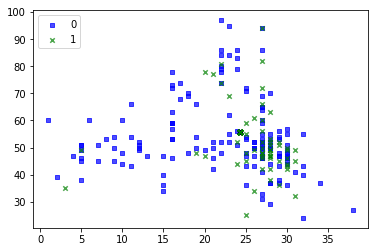

In [19]:
# 看下age、score散点分布：

import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter

fig = category_scatter(
    x='age', 
    y='score', 
    label_col='click', 
    data=train_df[train_df['user_id'] == 1000], 
    legend_loc='upper left'
)

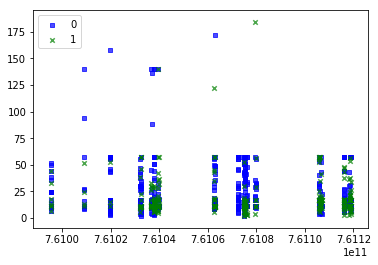

In [20]:
# 看下time、duration_time散点分布：
fig = category_scatter(
    x='time', 
    y='duration_time', 
    label_col='click', 
    data=train_df[train_df['user_id'] == 1000], 
    legend_loc='upper left'
)

In [21]:
# 时间具有周期性，转为0~24小时数
# time、age、score分布比较平均，用MinMaxScaler缩放到0~1
# duration_time有些离群点，用QuantileTransformer做数据变换

In [22]:
# 时间戳标准化为0~24小时
def to_hour(time):
    return int(time / 3600000) % 24

In [23]:
train_df['time'] = train_df['time'].apply(to_hour)
train_df.head()

,user_id,photo_id,time,duration_time,click,gender,age,score
0,1637,6484142,7,11,0,0.486066,24.287269,55.895569
1,1637,4647664,6,11,0,0.486066,24.287269,55.895569
2,1637,4994626,7,10,1,1.000000,27.000000,48.000000
3,1637,4416881,6,9,0,0.486066,24.287269,55.895569
4,1637,2597756,6,11,0,0.486066,24.287269,55.895569


In [24]:
from sklearn import preprocessing

train_df['age'] = preprocessing.MinMaxScaler().fit_transform(train_df['age'].values.reshape(-1, 1)).flatten()
train_df['score'] = preprocessing.MinMaxScaler().fit_transform(train_df['score'].values.reshape(-1, 1)).flatten()
train_df['time'] = preprocessing.MinMaxScaler().fit_transform(train_df['time'].values.reshape(-1, 1)).flatten()
train_df['duration_time'] = preprocessing.QuantileTransformer().fit_transform(train_df['duration_time'].values.reshape(-1, 1)).flatten()


/Users/sun/PycharmProjects/kuaishou/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [25]:
train_df.head()

,user_id,photo_id,time,duration_time,click,gender,age,score
0,1637,6484142,0.304348,0.400400,0,0.486066,0.612823,0.454374
1,1637,4647664,0.260870,0.400400,0,0.486066,0.612823,0.454374
2,1637,4994626,0.304348,0.193694,1,1.000000,0.684211,0.354430
3,1637,4416881,0.260870,0.133634,0,0.486066,0.612823,0.454374
4,1637,2597756,0.260870,0.400400,0,0.486066,0.612823,0.454374


## 清除数据

In [26]:
import gc

del train_face_df
del train_face_details_df
del train_face_columns
del train_face_path

del train_interaction_df
del train_interaction_columns
del train_interaction_path

gc.collect()

2835

## 验证集

取photo_id > 6750000的，作为验证集（新作品），约10%，这样更符合测试集中都是新作品的事实

In [27]:
valid_df = train_df[train_df['photo_id'] > 6750000]

In [28]:
valid_df.head()

,user_id,photo_id,time,duration_time,click,gender,age,score
21,1637,7300221,0.260870,0.079079,0,0.486066,0.612823,0.454374
30,1637,7090577,0.304348,0.613614,1,0.000000,0.684211,0.405063
47,1637,7427964,0.217391,0.709209,0,0.486066,0.612823,0.454374
52,1637,7115682,0.304348,0.990490,0,0.486066,0.612823,0.454374
56,1637,7089041,0.260870,0.613614,0,0.486066,0.612823,0.454374


## 训练集
剩余photo_id<=6750000的，作为训练集，约90%

In [29]:
train_df = train_df[train_df['photo_id'] <= 6750000]

In [30]:
train_df.head()

,user_id,photo_id,time,duration_time,click,gender,age,score
0,1637,6484142,0.304348,0.400400,0,0.486066,0.612823,0.454374
1,1637,4647664,0.260870,0.400400,0,0.486066,0.612823,0.454374
2,1637,4994626,0.304348,0.193694,1,1.000000,0.684211,0.354430
3,1637,4416881,0.260870,0.133634,0,0.486066,0.612823,0.454374
4,1637,2597756,0.260870,0.400400,0,0.486066,0.612823,0.454374


## 一个用户

研究一个用户的数据中gender、age、score与click的关系


In [31]:
user_id = 1000

train_X = train_df[train_df['user_id'] == user_id][['time', 'duration_time', 'gender', 'age', 'score']].values
train_y = train_df[train_df['user_id'] == user_id]['click'].values

In [32]:
train_X
train_y

array([0, 0, 0, ..., 0, 0, 0])

## 逻辑回归

In [33]:
from sklearn import linear_model

clf = linear_model.LogisticRegression()
clf.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
clf.coef_
clf.intercept_

array([-1.35989869])

In [35]:
# 验证集
valid_X = valid_df[valid_df['user_id'] == user_id][['time', 'duration_time', 'gender', 'age', 'score']].values
valid_y = valid_df[valid_df['user_id'] == user_id]['click'].values

In [36]:
# 预测click为1的概率
pred_y = clf.predict_proba(valid_X)[:,1]

In [38]:
# 预测值与真实值均方差
import numpy as np

np.mean((pred_y - valid_y)**2)

0.11865804107065023

In [39]:
# 方差分值：1 是完美的预测，0 意味着 X 和 y 线性不可分
clf.score(valid_X, valid_y)

0.8654708520179372

## 所有用户

使用上述方法为每个用户训练一个模型

In [40]:
# 每个用户训练一个逻辑回归模型，并导出

from sklearn.externals import joblib

for user_id in train_df['user_id'].unique():
    train_X = train_df[train_df['user_id'] == user_id][['time', 'duration_time', 'gender', 'age', 'score']].values
    train_y = train_df[train_df['user_id'] == user_id]['click'].values
    clf = linear_model.LogisticRegression()
    clf.fit(train_X, train_y)
    # 持久化为磁盘文件
    joblib.dump(clf, '../out/pred_user_interest_face_model/' + str(user_id))
    

## 预测

In [41]:
pred_df = valid_df[['user_id', 'photo_id', 'time', 'duration_time', 'gender', 'age', 'score']]
pred_df = pred_df.reindex(columns=['user_id', 'photo_id', 'time', 'duration_time', 'gender', 'age', 'score', 'click_probability'])

In [42]:
pred_df.head()

,user_id,photo_id,time,duration_time,gender,age,score,click_probability
21,1637,7300221,0.260870,0.079079,0.486066,0.612823,0.454374,NaN
30,1637,7090577,0.304348,0.613614,0.000000,0.684211,0.405063,NaN
47,1637,7427964,0.217391,0.709209,0.486066,0.612823,0.454374,NaN
52,1637,7115682,0.304348,0.990490,0.486066,0.612823,0.454374,NaN
56,1637,7089041,0.260870,0.613614,0.486066,0.612823,0.454374,NaN


In [43]:
# 装载预测模型

pred_models = {}

for user_id in pred_df['user_id'].unique():
    pred_models[user_id] = joblib.load('../out/pred_user_interest_face_model/' + str(user_id))
    

In [44]:
# 预测函数
def predict(row):
#     print(np.array([row['time'], row['duration_time'], row['area'], row['gender'], row['age'], row['score']]))
    user_id = int(row['user_id'])
    clf = pred_models[user_id]
    proba = clf.predict_proba(np.array([row['time'], row['duration_time'], row['gender'], row['age'], row['score']]).reshape(1, -1))[0, 1]
    return round(proba, 6)


In [45]:
# 预测填充click_probability列

import numpy as np

pred_df['click_probability'] = pred_df.apply(predict, axis = 1)

In [46]:
pred_df = pred_df[['user_id', 'photo_id', 'click_probability']]
pred_df.head()

,user_id,photo_id,click_probability
21,1637,7300221,0.239609
30,1637,7090577,0.272176
47,1637,7427964,0.195964
52,1637,7115682,0.177062
56,1637,7089041,0.201619


## 导出

In [47]:
# 导出预测结果
pred_df.to_csv('../out/pred_user_interest_face.txt', index=False, header=False, sep='\t')

## 评分

0.7069625893799051 - 平均值法

0.7097285003232818 - duration_time

0.6189868898378826 - time(周期变换为ms)、duration_time(非线性变换)

0.7149841956620693 - time(周期变换为hour)、duration_time(非线性变换)

0.7205338901676025 - time(周期变换为hour)、duration_time(非线性变换)，gender、age、score补全方式为0

0.7179047958068454 - time(周期变换为hour)、duration_time(非线性变换)，gender、age、score补全方式为mean

In [48]:
%run evaluation_script.py ../out/pred_user_interest_face.txt ../out/valid.txt

{'code': 0, 'message': 'validation success'}
{'code': 0, 'score': 0.7179047958068454, 'message': 'success'}
